In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '.')))
if 'ilya' in os.getcwd():
    os.chdir('/Users/ilya/Documents/Kaggle_Bimbo/')
elif 'romul' in os.getcwd():
    os.chdir('/home/romul/kaggle/Bimbo/')
else:
    os.chdir('/Users/margarita/Kaggle/Bimbo/')

Populating the interactive namespace from numpy and matplotlib


Пока что начнем с копипасты с кагла.

In [28]:
products  =  pd.read_csv("producto_tabla.csv")

products['short_name'] = products.NombreProducto.str.extract('^(\D*)', expand=False)
products['brand'] = products.NombreProducto.str.extract('^.+\s(\D+) \d+$', expand=False)
w = products.NombreProducto.str.extract('(\d+)(Kg|g)', expand=True)
products['weight'] = w[0].astype('float')*w[1].map({'Kg':1000, 'g':1})
products['pieces'] =  products.NombreProducto.str.extract('(\d+)p ', expand=False).astype('float')
print(products.shape[0])
products.head()

2592


,Producto_ID,NombreProducto,short_name,brand,weight,pieces
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,IDENTIFICADO,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NES,750.0,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,LON,170.0,NaN
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,TR,45.0,4.0


In [29]:
print(products.NombreProducto.nunique(), products.short_name.nunique())

2592 1014


Названия некоторых продуктов начинается с цифры, поэтому short_name получается пустой строкой.

In [30]:
products[products.short_name == ""] 

,Producto_ID,NombreProducto,short_name,brand,weight,pieces
57,714,7 Granos 680g ORO 714,,ORO,680.0,NaN
365,9753,100pct Whole Wheat 680g ORO 9753,,ORO,680.0,NaN
1819,37157,12 Tarima MiniMilk Kitty Nav 110g GBI 37157,,GBI,110.0,NaN
1860,37373,12Tarima Mini Milk Kitty SnVal 110g GBI 37373,,GBI,110.0,NaN
2080,43111,100pct Whole Wheat 680g MTA ORO 43111,,ORO,680.0,NaN
2102,43160,7 Granos 680g MTA ORO 43160,,ORO,680.0,NaN
2209,43364,12Granos Multigra TwinPack 1360g MTA ORO 43364,,ORO,1360.0,NaN
2479,48227,12Granos Multigra TwinPack 1360g TAB ORO 48227,,ORO,1360.0,NaN
2480,48228,7 Granos 680g TAB ORO 48228,,ORO,680.0,NaN


In [31]:
import re
# не умею в регулярки =(
def problem_processig(text):
    begin, end = None, None
    for i, char in enumerate(text):
        if not begin:
            if char.isupper():
                begin = i
            else:
                continue
        else:
            if char.isdigit():
                end = i - 1
                break
    return text[begin:end]

problem_index = products[products.short_name == ""].index
products.loc[problem_index, 'short_name'] = products[products.short_name == ""].NombreProducto.map(problem_processig)
products.loc[problem_index]  

,Producto_ID,NombreProducto,short_name,brand,weight,pieces
57,714,7 Granos 680g ORO 714,Granos,ORO,680.0,NaN
365,9753,100pct Whole Wheat 680g ORO 9753,Whole Wheat,ORO,680.0,NaN
1819,37157,12 Tarima MiniMilk Kitty Nav 110g GBI 37157,Tarima MiniMilk Kitty Nav,GBI,110.0,NaN
1860,37373,12Tarima Mini Milk Kitty SnVal 110g GBI 37373,Tarima Mini Milk Kitty SnVal,GBI,110.0,NaN
2080,43111,100pct Whole Wheat 680g MTA ORO 43111,Whole Wheat,ORO,680.0,NaN
2102,43160,7 Granos 680g MTA ORO 43160,Granos,ORO,680.0,NaN
2209,43364,12Granos Multigra TwinPack 1360g MTA ORO 43364,Granos Multigra TwinPack,ORO,1360.0,NaN
2479,48227,12Granos Multigra TwinPack 1360g TAB ORO 48227,Granos Multigra TwinPack,ORO,1360.0,NaN
2480,48228,7 Granos 680g TAB ORO 48228,Granos,ORO,680.0,NaN


In [32]:
products.short_name.value_counts(dropna=False)[:10]

Pan Blanco                39
Tortillinas               37
Deliciosas Vainilla       35
Medias Noches             25
Wonder                    22
Pan Integral              19
Suavicremas Chocolate     17
Suavicremas Vainilla      17
Deliciosas Chochitos      17
Canelitas                 17
Name: short_name, dtype: int64

In [33]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words("spanish")

[nltk_data] Downloading package stopwords to /Users/ilya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
products['short_name_processed'] = (products['short_name']
                                        .map(lambda x: " ".join([i for i in x.lower().split()
                                                                             if i not in stop])))
products['short_name_processed'].nunique()

996

In [35]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")

products['short_name_processed'] = products['short_name_processed']
                                        .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()]))

products.short_name_processed.nunique()

967

In [36]:
products[['NombreProducto', 'short_name_processed']].head(10)

,NombreProducto,short_name_processed
0,NO IDENTIFICADO 0,identific
1,Capuccino Moka 750g NES 9,capuccin mok
2,Bimbollos Ext sAjonjoli 6p 480g BIM 41,bimboll ext sajonjoli
3,Burritos Sincro 170g CU LON 53,burrit sincr
4,Div Tira Mini Doradita 4p 45g TR 72,div tir mini doradit
5,Pan Multigrano Linaza 540g BIM 73,pan multigran linaz
6,Tostado Integral 180g WON 98,tost integral
7,Pan Blanco 567g WON 99,pan blanc
8,Super Pan Bco Ajonjoli 680g SP WON 100,sup pan bco ajonjoli
9,Wonder 100pct mediano 475g WON 106,wond


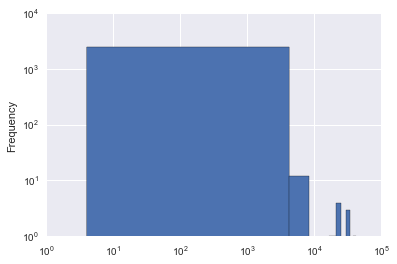

In [46]:
products['weight'].plot.hist(bins=10, logx=True, logy=True)

In [50]:
products['short_name_processed2'] = products['short_name_processed'].map(str) + ' ' +  pd.qcut(products['weight'], 10).astype(str).str.replace(' ', '') + ' ' + products['brand'].astype(str)
products[['NombreProducto', 'short_name_processed', 'short_name_processed2']].head(10)

,NombreProducto,short_name_processed,short_name_processed2
0,NO IDENTIFICADO 0,identific,identific nan IDENTIFICADO
1,Capuccino Moka 750g NES 9,capuccin mok,"capuccin mok (680,42000] NES"
2,Bimbollos Ext sAjonjoli 6p 480g BIM 41,bimboll ext sajonjoli,"bimboll ext sajonjoli (340,493.2] BIM"
3,Burritos Sincro 170g CU LON 53,burrit sincr,"burrit sincr (124,180] LON"
4,Div Tira Mini Doradita 4p 45g TR 72,div tir mini doradit,"div tir mini doradit [4,48] TR"
5,Pan Multigrano Linaza 540g BIM 73,pan multigran linaz,"pan multigran linaz (493.2,680] BIM"
6,Tostado Integral 180g WON 98,tost integral,"tost integral (124,180] WON"
7,Pan Blanco 567g WON 99,pan blanc,"pan blanc (493.2,680] WON"
8,Super Pan Bco Ajonjoli 680g SP WON 100,sup pan bco ajonjoli,"sup pan bco ajonjoli (493.2,680] WON"
9,Wonder 100pct mediano 475g WON 106,wond,"wond (340,493.2] WON"


In [51]:
products[['NombreProducto', 'short_name_processed', 'short_name_processed2']].describe()

,NombreProducto,short_name_processed,short_name_processed2
count,2592,2592,2592
unique,2592,967,1230
top,Bimbolunch 6p 354g ME TAB BIM 46226,tortillin,"tortillin (237,340] TR"
freq,1,40,20


In [52]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 1000) 

product_bag_words = vectorizer.fit_transform(products.short_name_processed2).toarray()
product_bag_words.shape

(2592, 733)

# Визуализация
Можно использовать как два дополнительных признака.

### t-SNE

In [53]:
from sklearn import manifold

tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 42)
TSNE_transformed = tsne.fit_transform(product_bag_words)

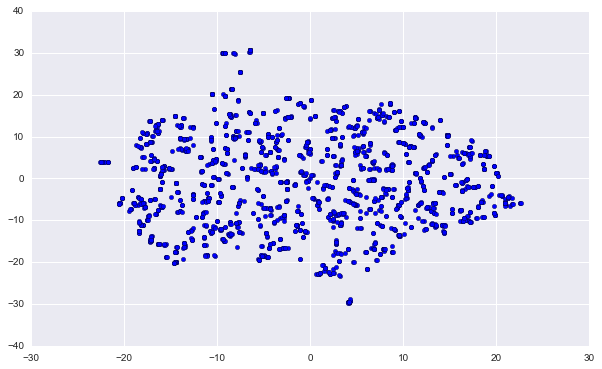

In [54]:
pylab.figure(figsize = (10, 6))
pylab.scatter(TSNE_transformed[:, 0], TSNE_transformed[:, 1])

###  MDS

In [55]:
from sklearn.metrics.pairwise import pairwise_distances

mds_cos = manifold.MDS(n_components=2, random_state=42)
MDS_transformed = mds_cos.fit_transform(product_bag_words)

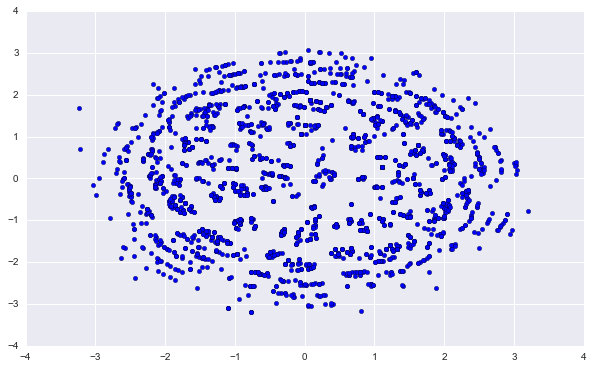

In [56]:
pylab.figure(figsize = (10, 6))
pylab.scatter(MDS_transformed[:, 0], MDS_transformed[:, 1])

Совсем плохо

Попробуем косинусную метрику на MDS

In [61]:
from sklearn.metrics.pairwise import pairwise_distances

mds_cos = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=42)
MDS_transformed_cos = mds_cos.fit_transform(pairwise_distances(product_bag_words, metric='cosine'))

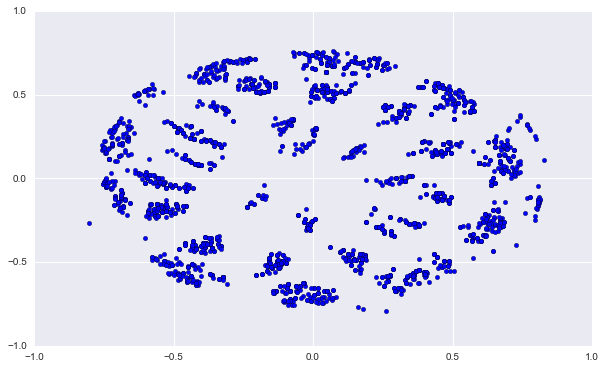

In [71]:
pylab.figure(figsize = (10, 6))
pylab.scatter(MDS_transformed_cos[:, 0], MDS_transformed_cos[:, 1])

Интересно получается. Это можно кластеризовать каким-нибудь DBSCAN, хотя не уверен что это что-то даст.

In [83]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=20, metric='euclidean')
y_db = db.fit_predict(MDS_transformed_cos)

In [84]:
from collections import Counter
Counter(y_db)

Counter({-1: 25,
         0: 176,
         1: 202,
         2: 264,
         3: 506,
         4: 272,
         5: 240,
         6: 130,
         7: 226,
         8: 215,
         9: 24,
         10: 97,
         11: 58,
         12: 24,
         13: 41,
         14: 70,
         15: 22})

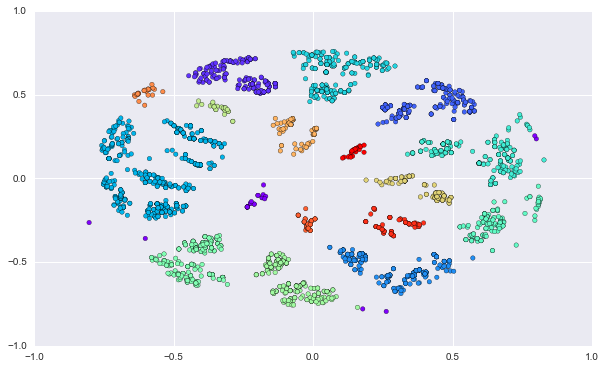

In [85]:
pylab.figure(figsize = (10, 6))
pylab.scatter(MDS_transformed_cos[:, 0], MDS_transformed_cos[:, 1], c=y_db, cmap='rainbow')

Часто встречаемые слова в кластерах.

In [86]:
for cluster in np.unique(y_db):
    print("Cluster %d:" % cluster, end=' ')
    print(Counter(" ".join(products.iloc[y_db == cluster].short_name).split()).most_common(4))

Cluster -1: [('Madalenas', 6), ('Fresa', 4), ('Roles', 3), ('Gansito', 3)]
Cluster 0: [('Pan', 48), ('Duo', 22), ('MM', 20), ('Bollos', 17)]
Cluster 1: [('Pan', 34), ('Bimbollos', 26), ('Tostada', 19), ('Bollos', 18)]
Cluster 2: [('Deliciosas', 49), ('Tubo', 41), ('Vainilla', 22), ('Suavicremas', 18)]
Cluster 3: [('Fresa', 62), ('Galleta', 41), ('Frut', 39), ('Barritas', 36)]
Cluster 4: [('Pan', 101), ('Blanco', 44), ('Super', 19), ('Tortillinas', 18)]
Cluster 5: [('Tortilla', 27), ('Noches', 20), ('Medias', 20), ('Tortillinas', 19)]
Cluster 6: [('Lata', 23), ('Tostada', 15), ('Burritos', 8), ('Deliciosas', 8)]
Cluster 7: [('Jamon', 20), ('Vainilla', 19), ('Triki', 19), ('Fresa', 16)]
Cluster 8: [('Duo', 29), ('Tartinas', 26), ('Fresa', 17), ('Submarinos', 16)]
Cluster 9: [('KC', 8), ('Barritas', 7), ('Canelitas', 4), ('Pina', 2)]
Cluster 10: [('Tubo', 13), ('Barra', 12), ('Multigrano', 11), ('Gansito', 11)]
Cluster 11: [('Pan', 15), ('KC', 11), ('Blanco', 9), ('Mi', 9)]
Cluster 12: [(

# Кластеризация

### KMeans

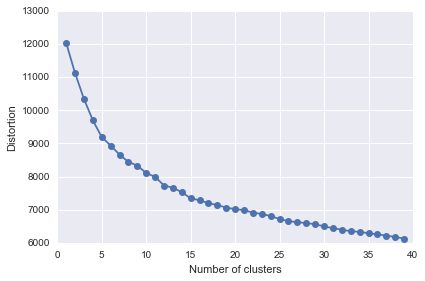

In [87]:
from sklearn.cluster import KMeans

distortions = []
max_clusters = 40
for i in range(1, max_clusters):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                random_state=42,
                n_jobs = -1)
    km.fit(product_bag_words)
    distortions.append(km.inertia_)
plt.plot(range(1, max_clusters), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('elbow.png', dpi=300)
plt.show()

С ростом кластеров SSE понемногу уменьшается, elbow методом не получается выяснить оптимальное количество кластеров.

In [88]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

n_clusters = 13 # количество кластеров

km = KMeans(n_clusters= n_clusters, 
            init='k-means++', 
            n_init=30, 
            random_state=0,
            n_jobs = -1)
y_km = km.fit_predict(product_bag_words)

Построим silhouette plot

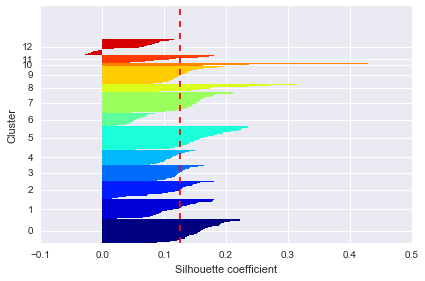

In [89]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(product_bag_words, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('silhouette.png', dpi=300)
plt.show()

Так себе кластеризация получается, но кое-какие продукты выделить удается.

In [90]:
Counter(y_km)

Counter({0: 299,
         1: 252,
         2: 237,
         3: 198,
         4: 196,
         5: 297,
         6: 166,
         7: 269,
         8: 102,
         9: 224,
         10: 37,
         11: 102,
         12: 213})

In [91]:
for cluster in range(n_clusters):
    print("Cluster %d:" % cluster, end=' ')
    print(Counter(" ".join(products.iloc[y_km == cluster].short_name).split()).most_common(10))

Cluster 0: [('Pan', 101), ('Blanco', 44), ('Super', 19), ('Tortillinas', 18), ('Multigrano', 17), ('Wonder', 17), ('KC', 13), ('Panera', 12), ('Noches', 11), ('Mi', 11)]
Cluster 1: [('Duo', 41), ('Tartinas', 26), ('Fresa', 21), ('Submarinos', 16), ('Chocolate', 15), ('Gansito', 14), ('Vainilla', 12), ('Pina', 12), ('mas', 12), ('Canapinas', 11)]
Cluster 2: [('Galleta', 33), ('Barritas', 29), ('Fresa', 29), ('Gansito', 23), ('Chocolate', 18), ('Nito', 12), ('Bigotes', 12), ('Rebanada', 12), ('Bombonete', 10), ('Pina', 9)]
Cluster 3: [('Pan', 48), ('Duo', 22), ('MM', 20), ('Bollos', 17), ('Blanco', 15), ('Multigrano', 12), ('Bimbollos', 11), ('Tortilla', 10), ('Integral', 9), ('BK', 8)]
Cluster 4: [('Tubo', 22), ('Nuez', 17), ('Suavicremas', 16), ('Tostado', 15), ('Lata', 15), ('Tostada', 13), ('Barra', 12), ('Multigrano', 11), ('Mantecadas', 10), ('Vainilla', 9)]
Cluster 5: [('Deliciosas', 49), ('Tubo', 44), ('Vainilla', 27), ('Suavicremas', 18), ('Chochitos', 18), ('Fresa', 16), ('Tost

Смысловых кластеров, увы, не вижу:( может быть, хотя бы в предсказании объемов поможет?
                                   
Сохраним:

In [95]:
products['Cluster'] = y_db
products.to_csv("producto_tabla_w_clusters.csv", index=False)